In [1]:
import streamlit as st
import os
from PIL import Image
import numpy as np
import pickle
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm
import cv2



In [2]:

feature_list = np.array(pickle.load(open('final_combined_features.pkl','rb')))
filenames = pickle.load(open('filenames.pkl','rb'))


In [5]:
 model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
 model.trainable = False

 model = tensorflow.keras.Sequential([
     model,
     GlobalMaxPooling2D()
 ])


In [6]:

img = image.load_img('sample/p13.png',target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
result = model.predict(preprocessed_img).flatten()
normalized_result = result / norm(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [7]:


# Using cosine similarity
neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean')
neighbors.fit(feature_list)






NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=10)

In [8]:

distances,indices = neighbors.kneighbors([normalized_result])

print(indices)


[[ 7144 32228  7087 31015  1281 24593 32233 18826  2593 18588]]


In [10]:
import faiss

# Convert your feature list to a float32 array (required by Faiss)
feature_list = np.array(feature_list).astype('float32')

# Build a Faiss index
index = faiss.IndexFlatL2(feature_list.shape[1])  # L2 is Euclidean distance
index.add(feature_list)  # Add your feature vectors to the index

# Perform a search
D, I = index.search(np.expand_dims(normalized_result, axis=0), 10)  # 10 neighbors

print("Top 10 Retrieved Indices:", I[0])


Top 10 Retrieved Indices: [ 7144 32228  7087 31015  1281 24593 32233 18826  2593 18588]


In [9]:
for file in indices[0][1:11]:
    temp_img = cv2.imread(filenames[file])
    cv2.imshow('output',cv2.resize(temp_img,(512,512)))
    cv2.waitKey(0)
    


In [11]:
def precision_at_k(retrieved_indices, relevant_indices, k):
    retrieved_k = set(retrieved_indices[:k])
    relevant_k = set(relevant_indices)
    return len(retrieved_k & relevant_k) / k

# Example usage
retrieved_indices = [0, 2, 3, 5, 6]  # Indices of images retrieved by your model
relevant_indices = [0, 1, 3, 4, 5]  # Indices of images that are relevant
precision = precision_at_k(retrieved_indices, relevant_indices, k=5)
print("Precision at 5:", precision)


Precision at 5: 0.6


In [12]:
def precision_at_k(retrieved_indices, relevant_indices, k):
    retrieved_k = set(retrieved_indices[:k])
    relevant_k = set(relevant_indices)
    return len(retrieved_k & relevant_k) / k

def recall_at_k(retrieved_indices, relevant_indices, k):
    retrieved_k = set(retrieved_indices[:k])
    relevant_k = set(relevant_indices)
    return len(retrieved_k & relevant_k) / len(relevant_k)

# Example usage
retrieved_indices = [0, 2, 3, 5, 6, 10, 12, 15, 20, 25]  # Model's retrieved indices
relevant_indices = [0, 1, 3, 4, 5, 6, 7, 8, 9]  # Known relevant indices
precision = precision_at_k(retrieved_indices, relevant_indices, k=5)
recall = recall_at_k(retrieved_indices, relevant_indices, k=10)
print("Precision at 5:", precision)
print("Recall at 10:", recall)


Precision at 5: 0.8
Recall at 10: 0.4444444444444444


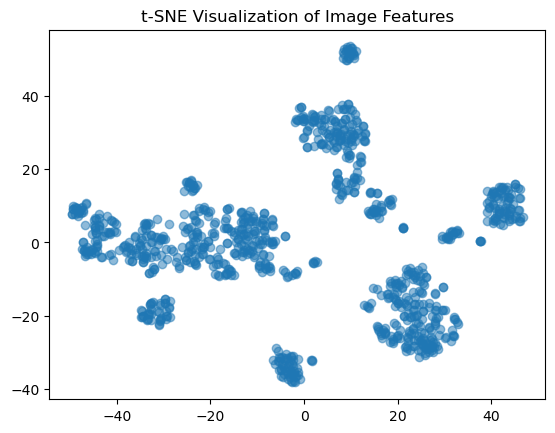

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_features = tsne.fit_transform(feature_list[:1000])  # Use a subset for efficiency

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.5)
plt.title("t-SNE Visualization of Image Features")
plt.show()
